In [1]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

In [4]:
chan_names = ecog_matfile['chan_names']

In [5]:
chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

In [6]:
chan_names

['P3_1_d',
 'P3_2_d',
 'F3_1_d',
 'F3_2_d',
 'C3_1_d',
 'C3_2_d',
 'C3_3_d',
 'C3_4_d',
 'T5_1_d',
 'T5_2_d',
 'T5_3_d',
 'T5_4_d']

In [7]:
raw_data.shape

(12, 136001)

In [8]:
mv_acc.shape

(1, 136001)

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
mmsc = MinMaxScaler(feature_range=(0, 1))                            
raw_data = mmsc.fit_transform(raw_data.T).T
mv_acc = mmsc.fit_transform(mv_acc.T).T

In [23]:
np.mean(raw_data,1)

array([ 0.59798084,  0.59972192,  0.55806013,  0.57636391,  0.58647832,
        0.5397835 ,  0.59351994,  0.55167488,  0.65607266,  0.61528411,
        0.47332576,  0.69402146])

In [24]:
np.mean(mv_acc,1)

array([ 0.57081284])

In [25]:
len_raw_data = raw_data.shape[1]

In [26]:
raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):]

mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

In [27]:
print(raw_data_train.shape)
print(raw_data_val.shape)
print(raw_data_test.shape)
print(mv_acc_train.shape)
print(mv_acc_val.shape)
print(mv_acc_test.shape)

(4, 45333)
(4, 22667)
(4, 68001)
(1, 45333)
(1, 22667)
(1, 68001)


In [28]:
mv_acc[0,::10].shape

(13601,)

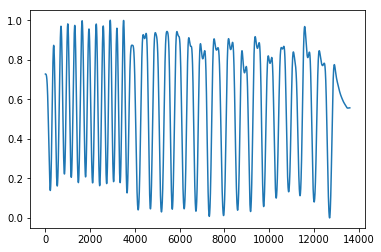

In [29]:
plt.plot(mv_acc[0,::10])

In [30]:
slice_len = 1000

In [31]:
def generate_slice(slice_len, val=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    else:
        X = raw_data_train
        y = mv_acc_train
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[:,slice_start:slice_end].T
        slice_y = y[0,slice_end]

        return slice_x, slice_y

In [32]:
tX, ty = generate_slice(slice_len)

In [33]:
tX.shape

(1000, 4)

In [34]:
ty

0.95540186877440036

In [35]:
def data_generator(batch_size, slice_len, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

In [36]:
slice_len = 2000

nb_filters = 10
kernel_size = 100

conv1d_act = "relu"

dense1_n = 30
dense1_act = "relu"

dense2_n = 30
dense2_act = "relu"

do = 0

path_to_save_model = 'testmodel2'

In [37]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [38]:
input_seq = Input(shape=(slice_len, 4))
convolved = Convolution1D(nb_filters, kernel_size, border_mode="same", activation=conv1d_act)(input_seq)
pooled = GlobalMaxPooling1D()(convolved)
dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
dense1do = Dropout(do)(dense1)
dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
dense2do = Dropout(do)(dense2)
out = Dense(1, activation='linear')(dense2do)

model = Model(input=input_seq, output=out)

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

from keras.callbacks import EarlyStopping, ModelCheckpoint

#nb_epoch = 100000



C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 200, activation="relu", padding="same")`
  
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [39]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

samples_per_epoch = 3000
nb_epoch = 200

In [40]:
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=32), samples_per_epoch, nb_epoch, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=1000, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=32, val=True))

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 3000, 200, callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., validation_steps=1000)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/200
3000/3000 [==============================] - 77s - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.1184 - val_mean_squared_error: 0.1184
Epoch 2/200
3000/3000 [==============================] - 72s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.1541 - val_mean_squared_error: 0.1541
Epoch 3/200
3000/3000 [==============================] - 72s - loss: 0.0651 - mean_squared_error: 0.0651 - val_loss: 0.1366 - val_mean_squared_error: 0.1366
Epoch 4/200
3000/3000 [==============================] - 75s - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 5/200
1844/3000 [=================>............] - ETA: 25s - loss: 0.0632 - mean_squared_error: 0.0632

KeyboardInterrupt: 

In [42]:
model = load_model('testmodel2_11')

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_mean_squared_error'])


NameError: name 'history' is not defined

In [44]:
tx, ty = generate_slice(slice_len = 3000, val=1)

In [45]:
a = np.ones((3,4,5))
b = np.ones((3,4,5))
c = np.concatenate((a[...,np.newaxis],b[...,np.newaxis]),axis=3)

txs = np.concatenate((tx[np.newaxis,:,:],tx[np.newaxis,:,:]),axis = 0)
txs.shape

(2, 3000, 4)

In [46]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],slice_len,4])
tys_0 = np.zeros([idxs.shape[0],1])

In [47]:
k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x = raw_data_test[:,slice_start:slice_end].T
    slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1
    

In [48]:
mv_acc_test.shape

(1, 68001)

In [49]:
txs_0.shape

(6501, 3000, 4)

In [50]:
tys_0.shape

(6501, 1)

In [51]:
tys_pred = model.predict(txs_0)

In [52]:
model.evaluate(txs_0,tys_0)

6432/6501 [============================>.] - ETA: 0s

[0.098134206771538862, 0.098134206771538862]

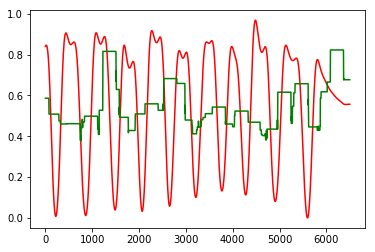

In [53]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()